# Emotions Go Particles
This notebook analyzes data generated from a study wherein people with schizophrenia and healthy controls were both instructed to watch a series of short videos (of varying emotional valence), then describe the videos and their reactions to the videos on camera. The videos were split into two groups; healthy controls (HC) watched only one group of videos (randomly assigned). The people with schizophrenia (PT for patients) watched both, each on separate days. On one of those days they had intranasal oxytocin administered to them, and on the other they were given a saline placebo. 

A team used an NLP emotion recognition model to summarize each subjects description of each stimulus with which they were presented into a vector of 28 emotions (including "no emotion"). Here, we coarsen that to 4 emotion groups (positive, negative, neutral, ambiguous) by simply summing, as the intial output is just a distribution.

The analysis presented here builds off of prior research indicating that people with schizophrenia may "mismap" emotions, particularly neutral or ambiguous emotions. Because we do not have any ground truth for the emotional content of the stimuli, we compare the reactions of the PTs to a "normative" response infered from the reactions of the HCs.

At a high level, we first assume that each stimulus has a fixed but unknown emotional distribution. We assume that HCs report that distribution back with only a small, unbiased (over the HC population) "random effect" noising plus some further measurement noise. We assume that there is some pre-noising/rotation of the stimuli's emotional distributions that occurs uniformly for all PTs prior to their "random effect" noising and the measurement noise. For oxytocin (OT), we add another unobserved rotation after the SZ rotation but before the "random effect" one.

## Notation and assumptions
* Set of stimuli $\left\{ i \right\}$
* Dirichlet prior param $\alpha$ 
  * We make extensive use of the [dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution), which is a distribution over distrubtions over finite, discrete outcomes or choices; in our case these are the 4 emotion groups.
* Random effect prior gamma prior means $\bar{\mu}^{re,d}$ and $\bar{\mu}^{re,r}$, for diagonal and off diagonal respectively
  * Details below, but these basically define our prior belief on how much an average person correctly identifies vs "misunderstands" a given emotional signal.
* Model precision magnitude param $\bar{o}$
* $\mathbf{1}_{4}=(1,1,1,1)$ and $\mathbf{e}_{2}=(0, 1, 0, 0)$ are a 1-vector and an axis or dimension vector.
* $\Delta^{3}$ is the 3 [simplex](https://en.wikipedia.org/wiki/Simplex), ie the space of vectors $\vec{u}$ of length 4 where $u_{1},u_{2},u_{3},u_{4}\geq 0$ and $u_{1}+u_{2}+u_{3}+u_{4}=1$

For each stimulus $i$ we have an emotion distribution $\vec{p}_{i}\in\Delta^{3}$ with prior
* $\vec{p}_{i} \sim Dir\left(\left(\alpha /4 \right) \mathbf{1}_{4} \right)$.

For patients with schizophrenia, we assume there is a "screen" between them and the video that "rotates" the video's emission distribution such that a particle of emotion $j$ emitted by the video and intercepted by this screen has an emission distribution of 
* $\vec{\beta}_{j}\in\Delta^{3}$ 
* with prior 
  * $\vec{\beta}_{j} \sim Dir\left(\left(\alpha /4 \right) \mathbf{1}_{4} \right)$.

We then assume that every subject has a "personal" screen that does the same thing, but with a "personal" distribution. The personal distribution for subject $k$ taking a particle of emotion $j$ has dirichlet distribution

* $\vec{r}_{j,k} \vert \mu^{re,d}, \mu^{re,r} \sim Dir\left( \mu^{re,d}\mathbf{e}_{j} + \mu^{re,r} \mathbf{1}_{4} \right)$

* where the diagonal and off diagonal parameters have priors

  * $\mu^{re,d} \sim \Gamma\left(\alpha=2, \beta= \bar{\mu}^{re,d} \right)$

  * $\mu^{re,r} \sim \Gamma\left(\alpha=2, \beta= \bar{\mu}^{re,r} \right)$


So lets say the emotion of a particle emitted from a stimulus is $x_{0}$. Then the particle's value after passing through the first screen has distribution 
* $x_{1} \vert x_{0}, \text{SZ}_{k}, \vec{\beta} \sim Multinoulli\left(\vec{\beta}_{x_{0}}\right)$
* $x_{1} \vert x_{0}, \text{HC}_{k}, \vec{\beta} \sim \delta_{x_{0}}$

And after passing through the second screen 
$ x_{2} \vert x_{1}, k, \vec{r} \sim Multinoulli\left(\vec{r}_{x_{1}, k}\right)$

And $x_{2}$ is passed to the GoEmotions model. The model, however, is imperfect. We model its precision (inverse of its noise magnitude; using "precision" and "noise magnitude" colloquially) as 
* $\mathscr{o} \sim HalfCauchy\left(\bar{o}\right)$

And model what is received by our final metric as
$ y \vert x_{2}, \mathscr{o} \sim Dir\left( \mathscr{o} x_{2} \right)$



In [1]:
# Imports
%pylab inline
import model as go_model_module
import preprocess as go_preprocess
import pathlib
import pandas as pd
import arviz as az
import pymc3 as pm


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read data
data_path = pathlib.Path("go_emotions_output_clean.csv")
with data_path.open("r") as fl:
    raw_data = pd.read_csv(fl)
raw_data.sample(5)


,id,stimulus.x,drugCondition,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
129,7020,neg_heart,PL,0.047561,0.000298,0.000907,0.001411,0.005143,0.005001,0.027571,...,0.001466,0.001497,0.003138,0.001040,0.002599,0.002866,0.025079,0.002044,0.248152,0.001933
402,7079,neg_broken,PL,0.003435,0.004181,0.008184,0.003153,0.002299,0.928852,0.000589,...,0.002830,0.008798,0.057432,0.000884,0.000698,0.004899,0.001765,0.002966,0.421313,0.001096
140,7022,joy_phone,OT,0.008664,0.905289,0.002611,0.001807,0.002428,0.001362,0.002479,...,0.003009,0.000109,0.002109,0.002217,0.000360,0.000961,0.001238,0.000468,0.002945,0.000878
162,7027,joy_baby,OT,0.003188,0.123291,0.000493,0.002140,0.002492,0.000521,0.001766,...,0.000611,0.000851,0.002550,0.004523,0.000495,0.012505,0.003956,0.001058,0.054917,0.000535
251,7045,joy_baby,OT,0.014088,0.896613,0.002026,0.001275,0.015811,0.001191,0.041970,...,0.002665,0.000179,0.002691,0.001461,0.000634,0.002126,0.002521,0.000474,0.001556,0.004301


## How to preprocess?
First, fix the typos in the stimulus names (done ahead... hence the _clean.csv filename). 

Next, the emotions in the raw data almost always sum to more than 1, but each entry is bounded by (0, 1). Given that I know the model has cross-entropy loss, my first guess is that it yielded initial results for the 27 emotions as real numbers and someone just took logits. Below are plots of the distributions of entropy (for the coarsened distributions) if we
* Follow my hypothesis, take logits then softmax
  * Everything bunches at 0. This looks awful. Basically, it would mean that every sample was 100% one emotion. 
* Softmax
  * Better, but a weirdly high mode.
* Simply divide by the sum of the raw values to get the distribution... 
  * looks great!
  * Weird... not sure how the data would have ended up like this, but the entropy distribution sure looks like something I want to use, so let's go with it.

/Users/mhankin/Projects/SZEmotionGoParticles/preprocess.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  coarse_to_fine_emo_map = yaml.load(fl)
/Users/mhankin/Projects/SZEmotionGoParticles/preprocess.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  coarse_to_fine_emo_map = yaml.load(fl)
/Users/mhankin/Projects/SZEmotionGoParticles/preprocess.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  coarse_to_fine_emo_map = yaml.load(fl)


<Figure size 432x288 with 0 Axes>

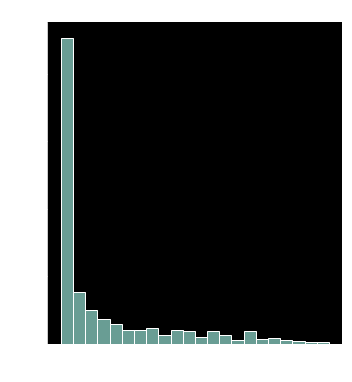

<Figure size 432x288 with 0 Axes>

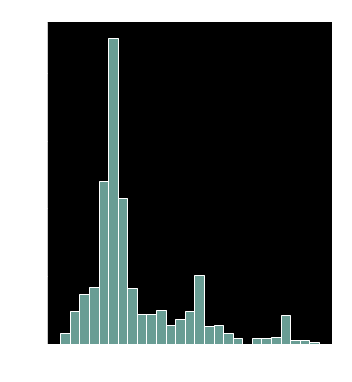

<Figure size 432x288 with 0 Axes>

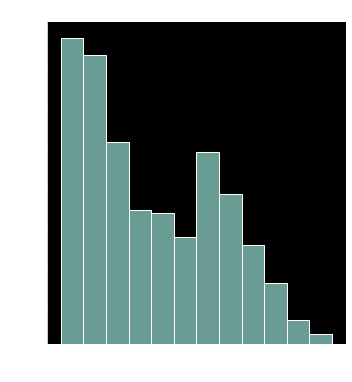

In [3]:
# How to preprocess data?
plt.figure()
hypothesis_df = go_preprocess.preprocess(raw_data, logit_first=True, power=None)
sns.displot((- hypothesis_df * np.log(hypothesis_df)).sum(1))
plt.title("Logit first, then softmax")
plt.xlabel("Entropy")
plt.figure()
hypothesis_no_logit_df = go_preprocess.preprocess(raw_data, logit_first=False, power=None)
sns.displot((- hypothesis_no_logit_df * np.log(hypothesis_no_logit_df)).sum(1))
plt.title("Softmax")
plt.xlabel("Entropy")
plt.figure()
df = go_preprocess.preprocess(raw_data, logit_first=False, power=1.0)
sns.displot((- df * np.log(df)).sum(1))
plt.title("Simple sum-then-divide to normalize (BEST!)")
plt.xlabel("Entropy");

In [4]:
df.sample(10)

,,,ambiguous,negative,neutral,positive
pid,stim,dc,,,,
7061,joy_grandpa,PL,0.005372,0.010552,0.003724,0.980352
7083,neg_coffer,OT,0.225965,0.061699,0.655170,0.057166
8024,neg_dying,HC,0.006168,0.971346,0.007637,0.014849
8032,neg_broken,HC,0.007201,0.180164,0.000333,0.812302
7005,joy_dogfail,PL,0.001881,0.003402,0.000654,0.994064
7033,neg_bugear,OT,0.292919,0.010818,0.000645,0.695619
8100,neg_coffer,HC,0.167167,0.554274,0.001565,0.276994
8004,neg_dying,HC,0.008665,0.900552,0.000844,0.089939
7079,neu_yawn,OT,0.002879,0.003312,0.987189,0.006621


## Sample from model
Choose fairly arbitrary prior values, but we'll confirm the priors get swamped by the data afterwards.

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 21900
Interrupted at 21,899 [43%]: Average Loss = -3,537.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_mag, beta_drug, random_effects, re_rest, re_diag, beta, normative_emo]


Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 1042 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'beta\nambiguous, ambiguous'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, ambiguous'}>],
       [<AxesSubplot:title={'center':'beta\nambiguous, negative'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, negative'}>],
       [<AxesSubplot:title={'center':'beta\nambiguous, neutral'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, neutral'}>],
       [<AxesSubplot:title={'center':'beta\nambiguous, positive'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, positive'}>],
       [<AxesSubplot:title={'center':'beta\nnegative, ambiguous'}>,
        <AxesSubplot:title={'center':'beta\nnegative, ambiguous'}>],
       [<AxesSubplot:title={'center':'beta\nnegative, negative'}>,
        <AxesSubplot:title={'center':'beta\nnegative, negative'}>],
       [<AxesSubplot:title={'center':'beta\nnegative, neutral'}>,
        <AxesSubplot:title={'center':'beta\nnegative, neutral'}>],
       [<AxesSubplot:title={'center':'beta\nneg

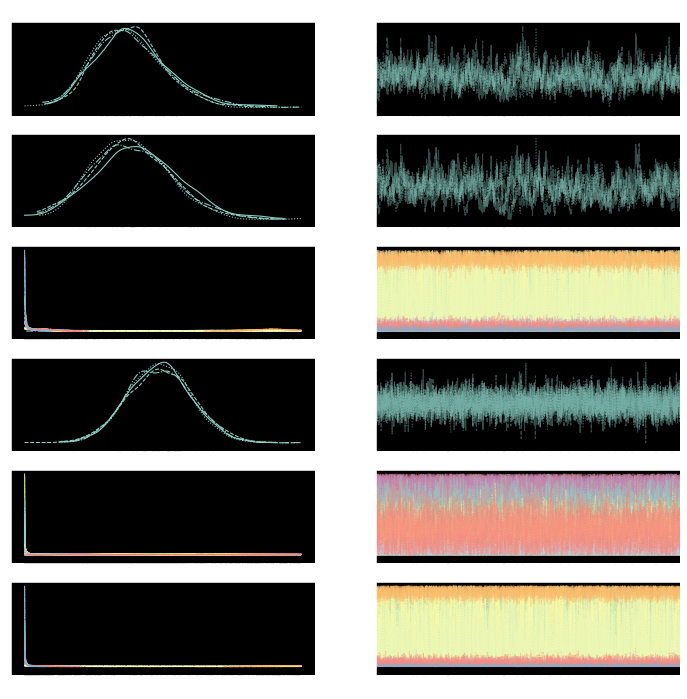

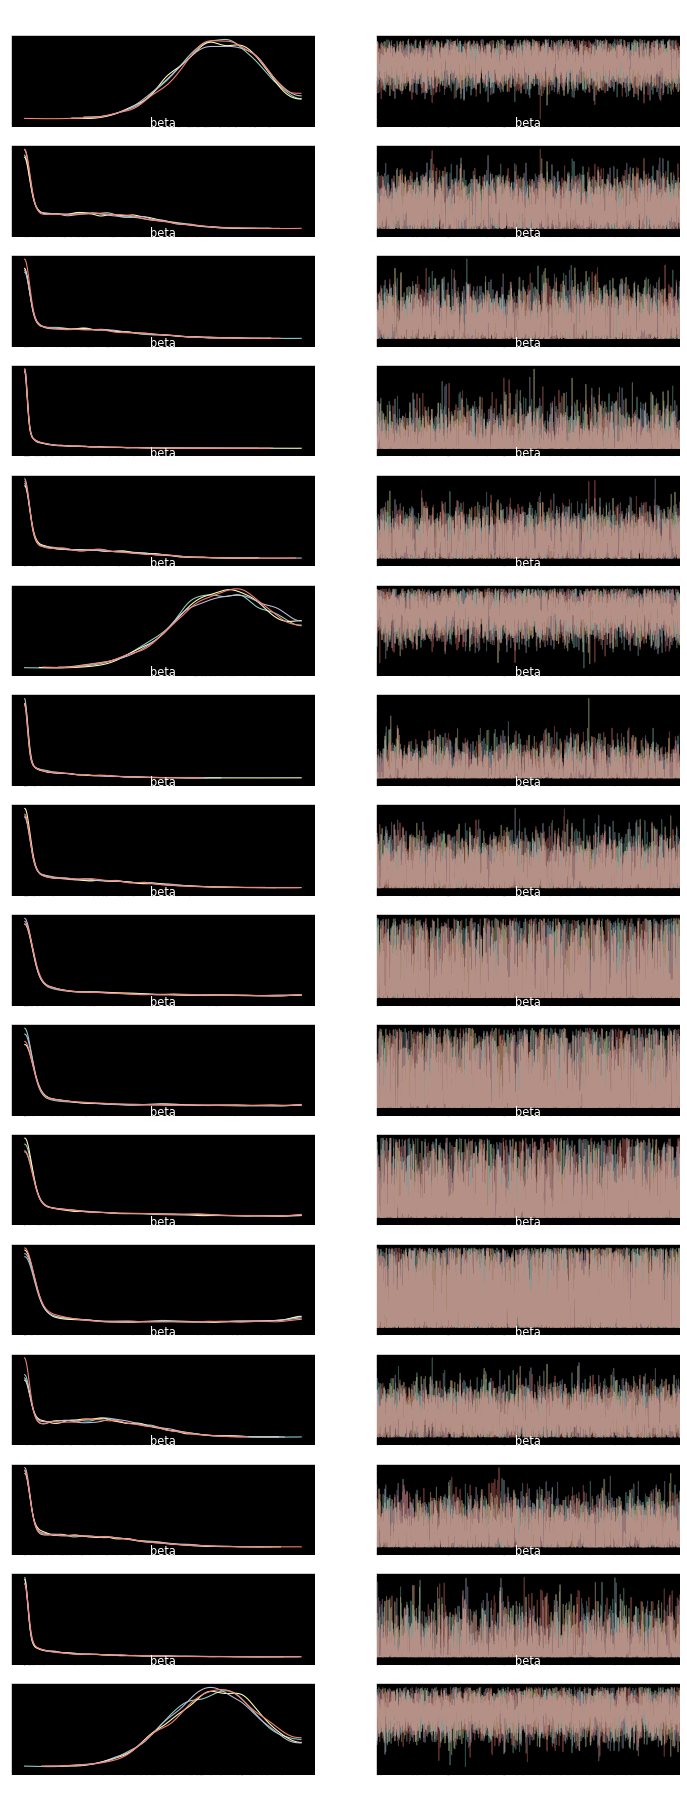

In [5]:

include_ot = True
model = go_model_module.bayesian_model(df.reset_index(), list(df.columns), include_ot=include_ot, inv_alpha=1.0)
samples = pm.sample(
    2500, 
    model=model, 
    return_inferencedata=True, 
    tune=2500, 
    chains=4, 
    init="advi+adapt_diag",
    n_init=50000
)

with model:
    prior = pm.sample_prior_predictive()
    prior = az.from_pymc3(prior=prior)
samples.extend(prior)

trace_vars = ["re_diag", "re_rest", "beta", "obs_mag", "normative_emo"]
if include_ot:
    trace_vars.append("beta_drug")
az.plot_trace(
    samples,
    var_names=trace_vars,
    compact=True,
)
az.plot_trace(
    samples,
    var_names=["beta"],
    compact=False,
)

In [9]:
display(samples)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

<AxesSubplot:xlabel='beta_drug', ylabel='emo'>

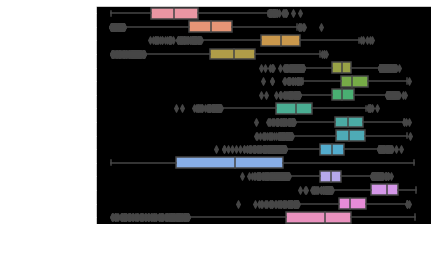

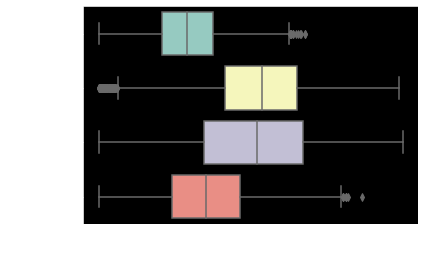

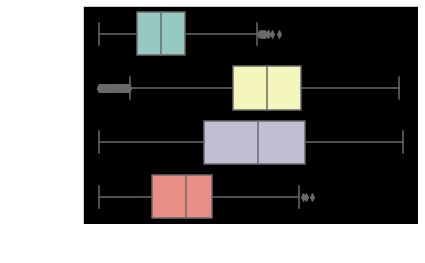

In [11]:
def calc_entropy(da: xr.DataArray, dim: str) -> xr.DataArray:
    return (-da * np.log(da)).sum(dim)

entropy_dim_map = {"normative_emo":"emo",
"beta":"emo_to",
"random_effects":"emo_to",
"beta_drug":"emo_to"
}
entropy_ds = xr.Dataset({var: calc_entropy(samples.posterior[var], dim) for var, dim in entropy_dim_map.items()})
emo_order = ["positive", "ambiguous", "neutral", "negative"]
plt.figure()
sns.boxplot(data=entropy_ds["normative_emo"].to_series().reset_index(), x="normative_emo", y="stim")
plt.figure()
sns.boxplot(data=entropy_ds["beta"].to_series().reset_index(), x="beta", y="emo", order=emo_order)
plt.figure()
sns.boxplot(data=entropy_ds["beta_drug"].to_series().reset_index(), x="beta_drug", y="emo", order=emo_order)



<AxesSubplot:xlabel='beta_drug', ylabel='emo'>

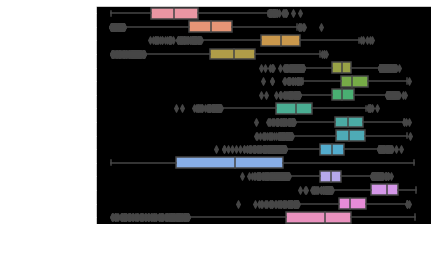

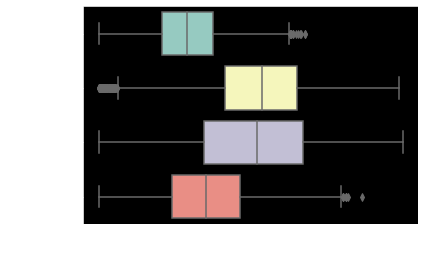

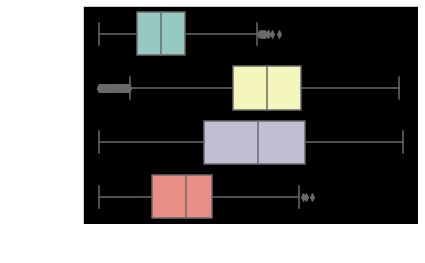

In [12]:
plt.figure()
sns.boxplot(data=entropy_ds["normative_emo"].to_series().reset_index(), x="normative_emo", y="stim")
plt.figure()
sns.boxplot(data=entropy_ds["beta"].to_series().reset_index(), x="beta", y="emo", order=emo_order)
plt.figure()
sns.boxplot(data=entropy_ds["beta_drug"].to_series().reset_index(), x="beta_drug", y="emo", order=emo_order)



<AxesSubplot:xlabel='emo', ylabel='PostMeanEnt'>

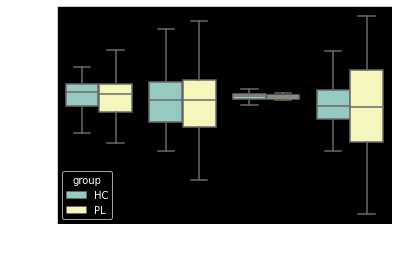

In [16]:
# Group random effect entropy comparison
# Medians should line up well between groups (difference was handled by group effect)
# but spreads may be different, indicating a difference in intragroup variabilty
# Very kludgey way of getting PID to group map
temp_df = pd.read_csv("/Users/mhankin/Projects/SZEmotionGoParticles/go_emotions_output_clean.csv")
temp_df = temp_df[temp_df["drugCondition"]!="OT"]
subject_group_map = {pid_dc[0]:pid_dc[1] for pid_dc, _ in temp_df.groupby(["id", "drugCondition"])}
re_entropyd_df = entropy_ds["random_effects"].to_series().reset_index()
re_entropyd_df["group"] = re_entropyd_df["pid"].apply(subject_group_map.get)
plt.figure()
person_emo_mean_posterior_entropy_df = re_entropyd_df.groupby(["group", "emo", "pid"])["random_effects"].mean()
person_emo_mean_posterior_entropy_df.name = "PostMeanEnt"
person_emo_mean_posterior_entropy_df = person_emo_mean_posterior_entropy_df.reset_index()
sns.boxplot(data=person_emo_mean_posterior_entropy_df, x="emo", y = "PostMeanEnt", hue="group", showfliers=False)


<AxesSubplot:xlabel='emo_to', ylabel='emo'>

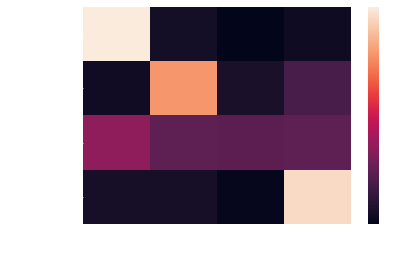

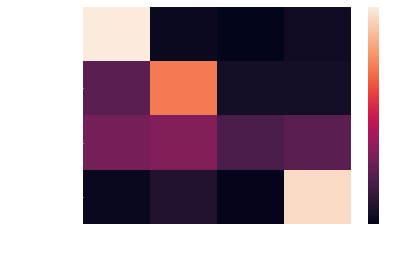

In [17]:
# Heatmap of posterior means of beta rotation matrices

plt.figure()
beta_posterior_means = samples.posterior["beta"].mean(["chain", "draw"]).to_series().unstack("emo_to")[emo_order].loc[emo_order, :]
sns.heatmap(beta_posterior_means)
plt.figure()
beta_drug_posterior_means = samples.posterior["beta_drug"].mean(["chain", "draw"]).to_series().unstack("emo_to")[emo_order].loc[emo_order, :]
sns.heatmap(beta_drug_posterior_means)

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='re_diag'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='re_rest'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, ambiguous'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, negative'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, neutral'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, positive'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, ambiguous'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, negative'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, neutral'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, positive'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabe

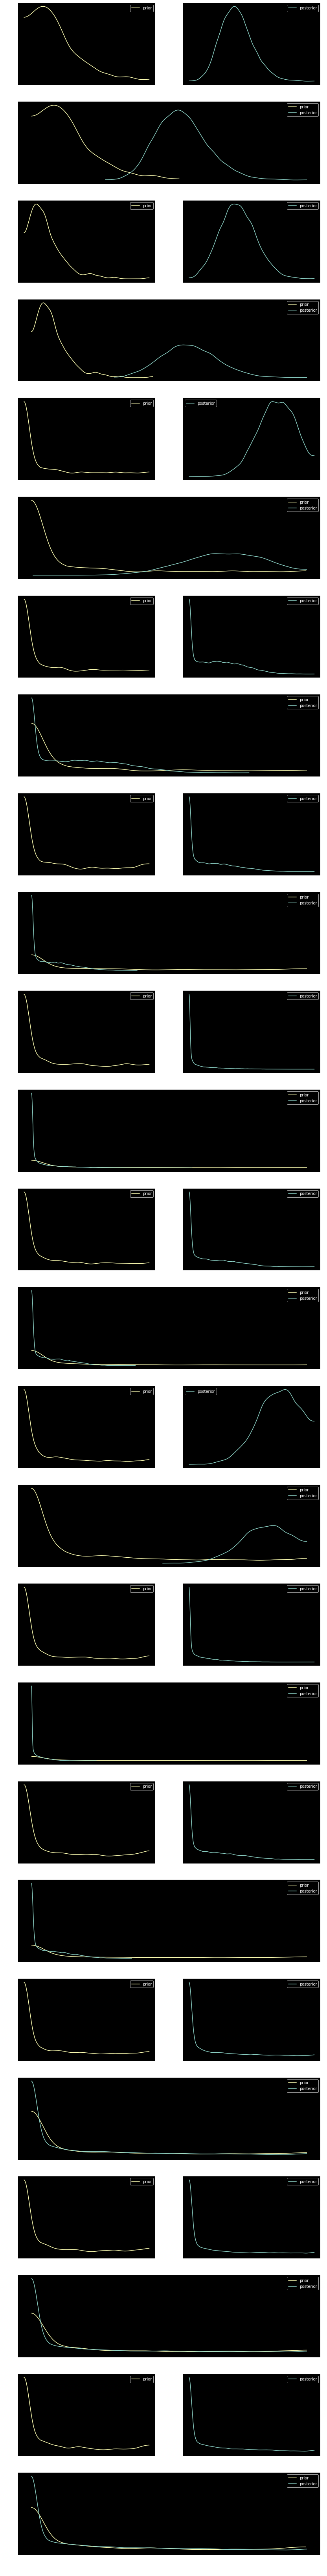

In [22]:
# Prior vs Posterior comparison
az.plot_dist_comparison(samples, var_names=trace_vars, )